In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys
sys.path.append('..')
from clusterizer.algorithms import clusterize_poisson, cluster_boolean_series
from clusterizer.cluster import Cluster
from clusterizer.circuit import MergedCircuit
from clusterizer.plot import draw_location_time_scatter, overlay_cluster

In [48]:
circuit = MergedCircuit(2063)
circuit.build()
#circuit.pd

In [49]:
#draw_location_time_scatter(circuit)

In [50]:
clusters, bins, bin_contents, rate = clusterize_poisson(circuit)
for cluster in clusters:
    print(cluster)

492m to 544m
256m to 288m
328m to 364m
0m to 12m
576m to 628m


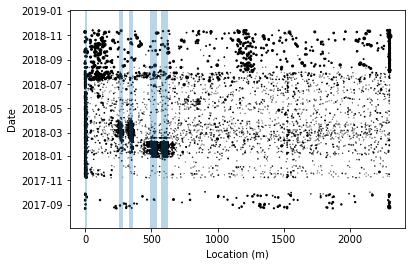

In [57]:
draw_location_time_scatter(circuit)
for cluster in clusters:
    overlay_cluster(cluster)

In [78]:
def bin_times(partial_discharges, bin_size):
    """
    Create a histogram of partial discharges in the time dimension
    """
    time_column = partial_discharges.columns[0]
    convert_times = lambda s: datetime.datetime.strptime(str(s), "%Y-%m-%d %H:%M:%S")
    cluster_times = partial_discharges[time_column].apply(convert_times)
    start_time = cluster_times[cluster_times.index[0]]
    stop_time = cluster_times[cluster_times.index[-1]]
    bins = np.arange(start = start_time, stop = stop_time, step = bin_size)
    binned_pds, _ = np.histogram(cluster_times, bins=bins)
    return binned_pds, bins

def pds_in_cluster(partial_discharges, cluster):
    xmin = cluster.location_range[0]
    xmax = cluster.location_range[1]
        
    location_column = partial_discharges.columns[1]
    in_cluster = [xmin <= loc <= xmax for loc in partial_discharges[location_column]]
    cluster_pds = partial_discharges[in_cluster]
    return cluster_pds
    
def time_clustering(circuit, clusters, bin_size = datetime.timedelta(days=1)):
    time_column, location_column, charge_column = circuit.pd.columns
    pardis = circuit.pd[circuit.pd_occured]
    
    result = []
    
    for cluster in clusters:
        cluster_pds = pds_in_cluster(pardis, cluster)
        
        binned_pds, bins = bin_times(cluster_pds, bin_size)
        average = np.mean(binned_pds)
        
        boolean_pds_fault = binned_pds > average
        index_time_cluster_edges = cluster_boolean_series(boolean_pds_fault)
        for index_time_cluster in index_time_cluster_edges:
            tmin = bins[index_time_cluster[0]]
            tmax = bins[index_time_cluster[1]]
            location_time_cluster = Cluster(location_range=cluster.location_range, time_range=(tmin, tmax))
            result.append(location_time_cluster)
    return result

In [79]:
time_clusters = time_clustering(circuit, clusters)
for cluster in time_clusters:
    print(cluster)

492m to 544m; 2017-12-29T17:20:00.000000 until 2018-02-05T17:20:00.000000
492m to 544m; 2018-06-24T17:20:00.000000 until 2018-06-29T17:20:00.000000
256m to 288m; 2018-04-22T19:29:00.000000 until 2018-04-28T19:29:00.000000
256m to 288m; 2018-01-06T19:29:00.000000 until 2018-04-07T19:29:00.000000
256m to 288m; 2018-07-07T19:29:00.000000 until 2018-07-31T19:29:00.000000
256m to 288m; 2018-05-12T19:29:00.000000 until 2018-05-27T19:29:00.000000
328m to 364m; 2018-01-19T17:13:00.000000 until 2018-01-24T17:13:00.000000
328m to 364m; 2018-02-04T17:13:00.000000 until 2018-03-30T17:13:00.000000
0m to 12m; 2018-04-13T00:25:00.000000 until 2018-05-06T00:25:00.000000
0m to 12m; 2018-05-14T00:25:00.000000 until 2018-06-11T00:25:00.000000
0m to 12m; 2018-02-09T00:25:00.000000 until 2018-04-07T00:25:00.000000
0m to 12m; 2018-06-21T00:25:00.000000 until 2018-07-31T00:25:00.000000
0m to 12m; 2017-11-08T00:25:00.000000 until 2018-02-03T00:25:00.000000
576m to 628m; 2017-12-29T15:35:00.000000 until 2018-0

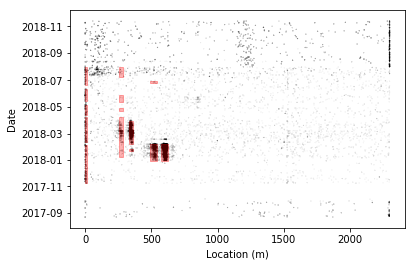

In [83]:
draw_location_time_scatter(circuit, dot_size_to_charge_ratio=1e6)
for cluster in time_clusters:
    overlay_cluster(cluster, color='r')